Implement the Sparse auto-encoder and the Contractive Auto-encoder. Use the MNIST digit dataset for
training your network. Use the U-Net auto-encoder architecture for encoder and decoder without skip
connections. Let E be the trained encoder and D be the trained decoder, h = E(I) be the embedding of
an image I and let ˆI = D(h) be the output of the decoder.
(a) (20 points) Plot the t-sne (use inbuilt function) on the embeddings obtained using the respective
auto-encoders. Color the clusters using the respective ground-truth class labels.
(b) (20 points) Randomly take two images I1 and I2 from two different digit classes. Let h1 = E(I1)
and h2 = E(I2) be the embeddings for these images, respectively. Construct another image Iα =
αI1+(1−α)I2 for α = 0, 0.2, 0.4, 0.6, 0.8, 1. Find the embedding hα of this image Iα for all values of α
by passing it through the encoder. Also, consider the approximate embedding h
′
α = αh1 + (1−α)h2
by using directly the embeddings of the images I1 and I2. Also, find ˆIα = D(hα) and ˆI
′
α = D(h
′
α).
Plot the images ˆIα and ˆI
′
α side by side for different values of α. Do this for 20 pairs (I1, I2). Report
PSNR between ˆIα and ˆI
′
α and find ∥hˆ
α − hˆ′
α∥2 for all values of alpha.
(c) (20 points) After training the autoencoders, you want to check if the embeddings of different digits
are different and embeddings within a class are similar. For this purpose, you propose to perform
the classification of the digits based on the embeddings obtained by the encoders and check the
accuracy of classifications for each of the Auto-encoder. Report the classification accuracy for each
of the AE and report which one is better. Use any inbuilt classifier to solve the classification
problem.

In [42]:
%pip install tensorflow numpy pandas matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

In [68]:
# Hyperparameters
batch_size = 128
epochs = 20 # Resetting epochs to original value
learning_rate = 0.001
sparse_lambda = 1e-3  # Sparsity penalty
contractive_lambda = 1e-4  # Contractive penalty
rho = 0.05  # Target sparsity
input_dim = 784
hidden_dim = 64
sparsity_level = 0.05
lambda_sparse = 0.1

# Load and preprocess MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
# Reshape data to include channel dimension and normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [136]:
import tensorflow as tf

def encoder_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x

def decoder_block(inputs, num_filters):
    x = layers.Conv2DTranspose(num_filters, 4, strides=2, padding='same', activation='relu')(inputs)      
    return x


def unet_model(input_shape=(28, 28, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    # Contracting Path (Encoder)
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    
    x = layers.Flatten()(s3)
    z = layers.Dense(128)(x)  # Latent space   
    # Expansive Path (Decoder)
    d1 = decoder_block(s3, 128)
    d2 = decoder_block(d1, 64)
    outputs = tf.keras.layers.Conv2DTranspose(1, 4,strides=2, padding='valid', activation='sigmoid')(d2)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model


In [137]:
autoencoder = unet_model()
autoencoder.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_325 (Conv2D)             │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_314 (Activation)     │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_156               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_326 (Conv2D)             │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_315 (Activation)     │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_157               │ (None, 7, 7, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_327 (Conv2D)             │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_316 (Activation)     │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 3, 3, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_97             │ (None, 6, 6, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_98             │ (None, 12, 12, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_99             │ (None, 26, 26, 1)      │         1,025 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026,241 (3.91 MB)

 Trainable params: 1,026,241 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
def sparse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y_true, y_pred))
    hidden_layer_output = encoder(y_true)
    mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)

    kl_divergence = tf.reduce_sum(sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
                                  (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation + 1e-10)))

    return mse_loss + lambda_sparse * kl_divergence

In [97]:
# Compile the Sparse Autoencoder - loss is handled in train_step
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=sparse_loss)

In [98]:
# Train the Sparse Autoencoder
history = autoencoder.fit(x_train, x_train, epochs=2,batch_size=256, shuffle=True)

Epoch 1/2


ValueError: Dimensions must be equal, but are 28 and 24 for '{{node compile_loss/sparse_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, U-Net_1/conv2d_260_1/Sigmoid)' with input shapes: [?,28,28,1], [?,24,24,1].

In [50]:
reconstructed = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


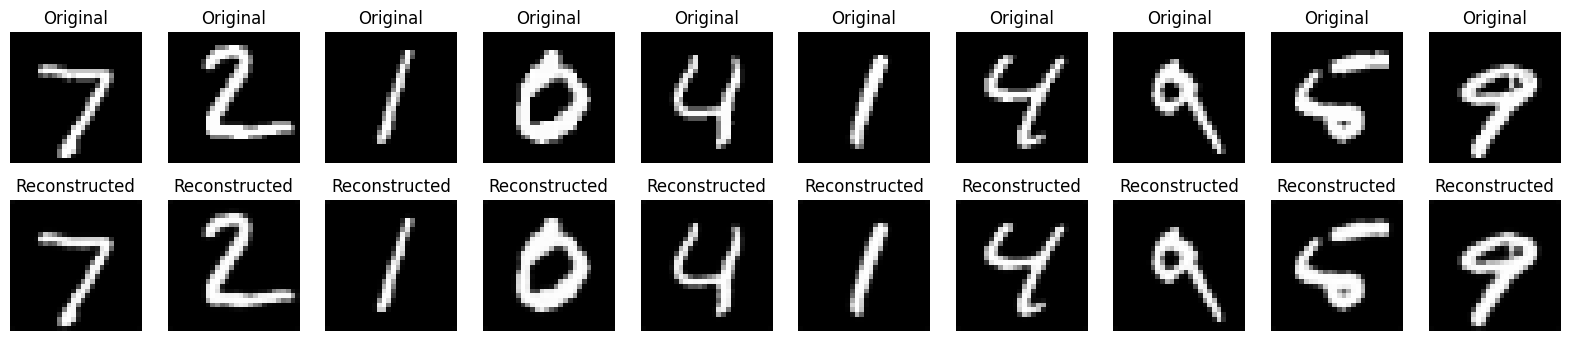

In [51]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()